In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [4]:
as_countries_data = pd.read_csv('as_data.csv', sep=';')

In [5]:
as_countries_data.head(15)

,ASN,Info
0,AS0,"-Reserved AS-, ZZ"
1,AS1,"LVLT-1, US"
2,AS2,"UDEL-DCN, US"
3,AS3,"MIT-GATEWAYS, US"
4,AS4,"ISI-AS, US"
5,AS5,"SYMBOLICS, US"
6,AS6,"BULL-HN, US"
7,AS7,"DSTL, EU"
8,AS8,"RICE-AS, US"
9,AS9,"CMU-ROUTER, US"


In [98]:
as_net_df = pd.read_csv('as.txt', sep='\t', header=None)
as_net = nx.from_pandas_edgelist(as_net_df, source=0, target=1)

In [12]:
print(as_net)

Graph with 6474 nodes and 13895 edges


In [57]:
as_countries_data['Location'] = as_countries_data.Info.str[-2:]

In [58]:
as_countries_data['Location'].value_counts()

US    4529
EU     407
CA     240
FR     126
NL     123
      ... 
FJ       1
MN       1
BD       1
KI       1
SV       1
Name: Location, Length: 111, dtype: int64

In [60]:
as_countries_data

,ASN,Info,Location
0,AS0,"-Reserved AS-, ZZ",ZZ
1,AS1,"LVLT-1, US",US
2,AS2,"UDEL-DCN, US",US
3,AS3,"MIT-GATEWAYS, US",US
4,AS4,"ISI-AS, US",US
...,...,...,...
6764,AS6996,"ALLST-6996, CA",CA
6765,AS6997,"SILLS-AS, US",US
6766,AS6998,"BRITEVOICE, US",US
6767,AS6999,"UU-ITNNET, US",US


In [69]:
from pycountry_convert import country_alpha2_to_continent_code


def countries_alpha_to_code(alpha):
    try:
        return country_alpha2_to_continent_code(alpha)
    except KeyError as _:
        # cuando no es un pais (caso EU)
        return alpha

as_countries_data['Continent'] = as_countries_data['Location'].apply(lambda alpha: countries_alpha_to_code(alpha))

In [70]:
as_countries_data.Continent.value_counts()

NA    4831
EU    1383
AS     338
OC      84
ZZ      58
SA      45
AF      30
Name: Continent, dtype: int64

In [74]:
# ZZ son todos aquellos AS que estan reservados
# lo que probablemente indica que el número es erroneo
# no hay data de esos sistemas autónomos en si
# por lo tanto se eliminan del análisis

# tomamos solo el numero
as_countries_data['ASN'] = as_countries_data['ASN'].str[-1:]

In [79]:
continent_dict = as_countries_data[['ASN', 'Continent']].to_dict()['Continent']

In [87]:
continent_dict_filtered = {k: v for k, v in continent_dict.items() if v != 'ZZ'}

In [93]:
continent_invalid_nodes = [asn for asn, continent in continent_dict.items() if continent == 'ZZ']

In [90]:
# continentes unicos
np.unique(list(continent_dict_filtered.values()))

array(['AF', 'AS', 'EU', 'NA', 'OC', 'SA'], dtype='<U2')

In [94]:
continent_invalid_nodes

[0,
 112,
 578,
 579,
 608,
 844,
 940,
 1277,
 1608,
 1618,
 1625,
 1762,
 2102,
 2103,
 2562,
 2706,
 2732,
 2811,
 2825,
 3059,
 3083,
 3085,
 3110,
 3485,
 3727,
 3732,
 3823,
 3963,
 4138,
 4369,
 4411,
 4462,
 4505,
 4754,
 4755,
 4763,
 4769,
 4780,
 4925,
 4980,
 5000,
 5383,
 5385,
 5486,
 5590,
 5899,
 5969,
 6015,
 6124,
 6136,
 6144,
 6317,
 6349,
 6396,
 6420,
 6436,
 6524,
 6704]

In [99]:
for asn in set(continent_invalid_nodes) & set(as_net.nodes):
    as_net.remove_node(asn)

In [100]:
print(as_net)

Graph with 6418 nodes and 13343 edges


In [101]:
for asn in as_net.nodes:
    as_net.nodes[asn]['Continent'] = continent_dict_filtered[asn]

In [106]:
largest_cc = max(nx.connected_components(as_net), key=len)

In [109]:
as_net_homophily = as_net.subgraph(largest_cc).copy()

In [111]:
# usamos la componente conexa mas grande para el analisis de homofilia
print(as_net_homophily)

Graph with 6367 nodes and 13340 edges


In [126]:
import matplotlib.pyplot as plt

continent_colors = {
    'AF': 'red',
    'NA': 'yellow',
    'SA': 'blue',
    'EU': 'green',
    'OC': 'brown',
    'AS': 'black',
}

pos = []

for continent in continent_colors.keys():
    pos.append(list(filter(lambda n: as_net.nodes[n]['Continent'] == continent, as_net.nodes)))

def draw_graph(g, positions):
    plt.figure(figsize=(12, 12), dpi=90)
    for position in positions:
        color = continent_colors[g.nodes[position[0]]['Continent']]
        new_g = g.subgraph(position).copy()
        position_subgraph = nx.spring_layout(position)
        nx.draw_networkx_nodes(new_g, position_subgraph, node_color=color, node_size=8)
        nx.draw_networkx_edges(new_g, position_subgraph, width=0.5,alpha=0.2)
    plt.axis('off')
    plt.figure(figsize=(50000,50000))
    plt.show()


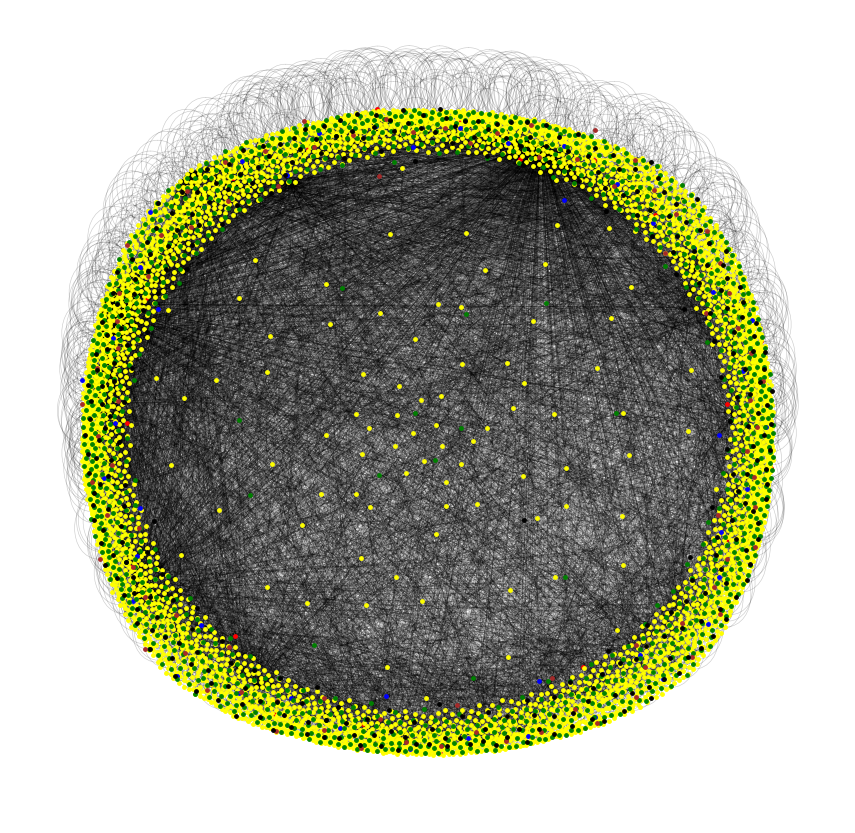

<Figure size 3.6e+06x3.6e+06 with 0 Axes>

In [127]:
draw_graph(as_net, pos)

In [128]:
""" Disclaimer: Tomado de https://github.com/mbuchwald/social-networks-utils/blob/main/homofilia.py"""
def contar_aristas(grafo):
    contador = 0
    for v in grafo:
        contador += len(list(grafo.neighbors(v)))
    return contador if nx.is_directed(grafo) else contador // 2


def proporcion_cruzan_campo(grafo, mapper=None):
    """
    :param grafo:
    :param mapper: un mapper de vertice a un tipo (por defecto, grafo[v])
    :return: devuelve la proporcion real que se obtiene de cruces respecto del total de aristas
    """
    aristas_totales = contar_aristas(grafo)
    cruzan_bloque = 0
    visitados = set()
    mapper = mapper if mapper is not None else (lambda k: grafo[k]["type"])

    for v in grafo:
        for w in grafo.neighbors(v):
            if not nx.is_directed(grafo) and w in visitados:
                continue
            if mapper(v) != mapper(w):
                cruzan_bloque += 1
        visitados.add(v)
    return cruzan_bloque / aristas_totales


def proporcion_por_tipo(grafo, mapper=None):
    """
    :param grafo:
    :param mapper: un mapper de vertice a un tipo (por defecto, grafo[v])
    :return: la proporcion que hay de cada tipo
    """
    mapper = mapper if mapper is not None else (lambda k: grafo[k]["type"])
    cantidades = {}
    for v in grafo:
        cantidades[mapper(v)] = cantidades.get(mapper(v), 0) + 1
    props = {}
    for c in cantidades:
        props[c] = cantidades[c] / len(grafo)
    return props


""" End disclaimer """

' End disclaimer '

In [129]:
crossing_proportion = proporcion_cruzan_campo(as_net, lambda x: as_net.nodes[x]["Continent"])
props = proporcion_por_tipo(as_net, lambda x: as_net.nodes[x]["Continent"])
probability_crossing = 0
for p in props:
    probability_crossing += props[p] * (1 - props[p])

In [130]:
crossing_proportion

0.3239025927969107

In [131]:
probability_crossing

0.41901705830662267

In [132]:
props

{'NA': 0.736833904643191,
 'EU': 0.18759738236210657,
 'AS': 0.05126207541290122,
 'OC': 0.013088189467123715,
 'AF': 0.004206918043004051,
 'SA': 0.007011530071673418}